In [8]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Dict
from scipy.optimize import dual_annealing
from copy import deepcopy
import os

from brancharchitect.io import read_newick
from brancharchitect.consensus_tree import get_taxa_circular_order
from brancharchitect.leaforder.leaf_order_distances import circular_distances_trees

from brancharchitect.consensus import (
    create_majority_consensus_tree,
    create_majority_consensus_tree_extended,
)


# Mapping function without Numba
def map_to_permutation(continuous_indices: np.ndarray) -> np.ndarray:
    """Map continuous indices to a valid permutation."""
    return np.argsort(continuous_indices)


# Function to compute MCTE consensus distance
def compute_mcte_consensus(tree_list: List):
    """Compute MCTE consensus tree distance."""
    mcte_tree = create_majority_consensus_tree_extended(tree_list)
    mcte_order = get_taxa_circular_order(mcte_tree)

    # Reorder the trees according to the MCTE order
    trees_copy = [deepcopy(tree) for tree in tree_list]
    for tree in trees_copy:
        tree._initialize_split_indices(mcte_order)
        tree._order = mcte_order
        tree._fix_child_order()

    mcte_avg_distance = circular_distances_trees(trees_copy)
    mcte_permutation = mcte_order

    return mcte_avg_distance, mcte_permutation


# Function to compute MC consensus distance
def compute_mc_consensus(tree_list: List):
    """Compute MC consensus tree distance."""
    mc_tree = create_majority_consensus_tree(tree_list)
    mc_order = get_taxa_circular_order(mc_tree)

    # Reorder the trees according to the MC order±
    trees_copy = [deepcopy(tree) for tree in tree_list]
    for tree in trees_copy:
        tree._initialize_split_indices(mc_order)
        tree._order = mc_order
        tree._fix_child_order()

    mc_avg_distance = circular_distances_trees(trees_copy)
    mc_permutation = mc_order

    return mc_avg_distance, mc_permutation


# Function to compute order from the first tree
def compute_first_tree_order(tree_list: List):
    """Get the circular order from the first tree in the list."""
    first_tree = tree_list[0]
    first_tree_order = get_taxa_circular_order(first_tree)
    return first_tree_order


# Evaluation function for circular distance
def eval_circular_distance(
    permutation_indices: np.ndarray,
    index_to_item: Dict[int, str],
    tree_list: List,
    callback=None,
):
    """Calculate average circular distance for a given permutation."""
    permutation = [index_to_item[i] for i in map_to_permutation(permutation_indices)]

    # Use deep copies to avoid modifying the original trees
    trees_copy = [deepcopy(tree) for tree in tree_list]

    # Reorder each tree according to the permutation
    for tree in trees_copy:
        tree._initialize_split_indices(permutation)
        tree._order = permutation
        tree._fix_child_order()

    distance = circular_distances_trees(trees_copy)

    if callback:
        callback(permutation, distance)

    return distance


# Simulated annealing optimization function with an option to choose initial order
def optimize_tree_order(
    file_path: str, initial_order_option: str = "mcte", max_iter: int = 25
):
    """Optimize tree order using simulated annealing with options for MCTE, MC, or first tree order."""
    # Read the tree list once
    tree_list = read_newick(file_path, None)

    # Choose initial order method
    if initial_order_option == "mcte":
        consensus_data, initial_order = compute_mcte_consensus(tree_list)
        print(f"Using MCTE for initial order. Distance: {consensus_data}")
    elif initial_order_option == "mc":
        consensus_data, initial_order = compute_mc_consensus(tree_list)
        print(f"Using MC for initial order. Distance: {consensus_data}")
    elif initial_order_option == "first_tree":
        initial_order = compute_first_tree_order(tree_list)
        print(f"Using first tree's order for initial order.")
    else:
        raise ValueError(
            "Invalid initial_order_option. Choose from 'mcte', 'mc', or 'first_tree'."
        )

    item_to_index = {item: idx for idx, item in enumerate(initial_order)}
    index_to_item = {idx: item for item, idx in item_to_index.items()}

    # Logging for optimization trajectory
    scores, permutations = [], []

    def logging_callback(permutation, score):
        scores.append(score)
        permutations.append(permutation)

    # Set up bounds and run optimization
    bounds = [(0, len(initial_order) - 1) for _ in initial_order]
    result = dual_annealing(
        eval_circular_distance,
        bounds=bounds,
        args=(index_to_item, tree_list, logging_callback),
        maxiter=max_iter,
    )

    best_permutation = [index_to_item[i] for i in map_to_permutation(result.x)]
    best_score = result.fun

    # Write permutation to file
    write_permutation_to_file(best_permutation, file_path, initial_order_option)

    # Plot optimization trajectory directly
    plt.figure(figsize=(12, 6))
    plt.plot(scores, "b-", label="Average Distance")
    plt.scatter(range(len(scores)), scores, color="red")
    plt.xlabel("Evaluation Step")
    plt.ylabel("Distance")
    plt.title("Distance Optimization Trajectory")
    plt.legend()
    plt.show()

    # Print final results
    print(f"Best permutation: {best_permutation}")
    print(f"Minimum average distance: {best_score}")


# Write best permutation to file
def write_permutation_to_file(best_permutation: List[str], file_path: str, method: str):
    """Write the best permutation to a file."""
    base_filename = os.path.basename(file_path).replace(".newick", "")
    output_filename = f"{base_filename}_{method}_order.txt"

    with open(output_filename, "w") as f:
        for element in best_permutation:
            f.write(f"{element}\n")

    print(f"Best permutation written to: {output_filename}")

Using first tree's order for initial order.
Best permutation written to: alltrees.trees_cutted_first_tree_order.txt


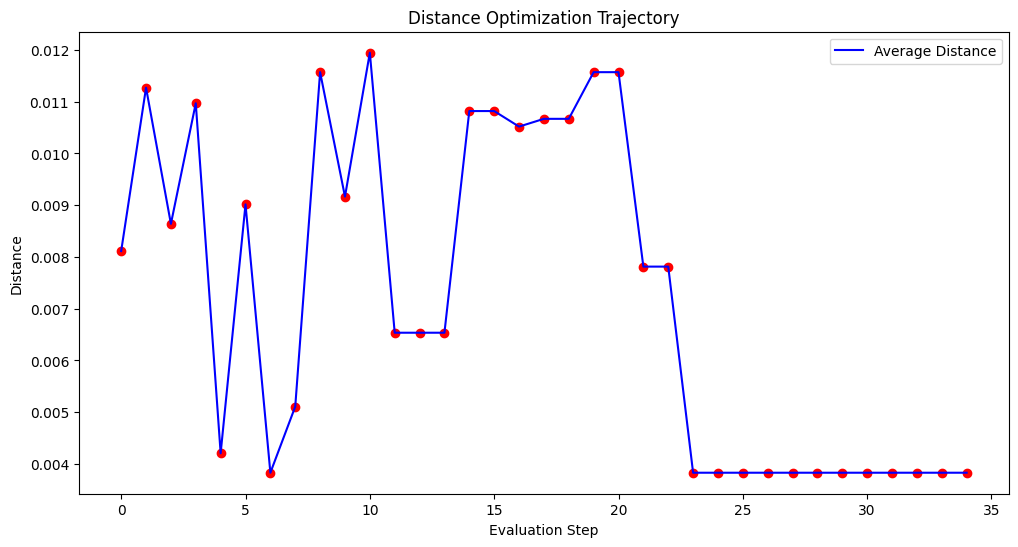

Best permutation: ['C2', 'D2', 'O2', 'B2', 'O1', 'A2', 'A1', 'D1', 'B1', 'X', 'C1']
Minimum average distance: 0.0038317054845980465
Using MC for initial order. Distance: 0.011570247933884297
Best permutation written to: alltrees.trees_cutted_mc_order.txt


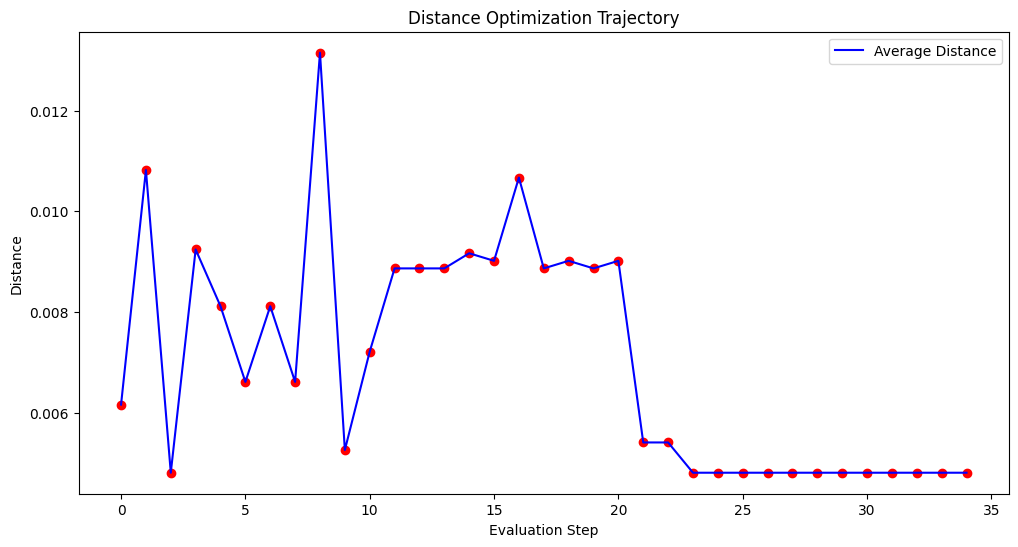

Best permutation: ['A1', 'B1', 'X', 'D2', 'C2', 'O2', 'D1', 'B2', 'C1', 'O1', 'A2']
Minimum average distance: 0.004808414725770097
Using MCTE for initial order. Distance: 0.011570247933884297
Best permutation written to: alltrees.trees_cutted_mcte_order.txt


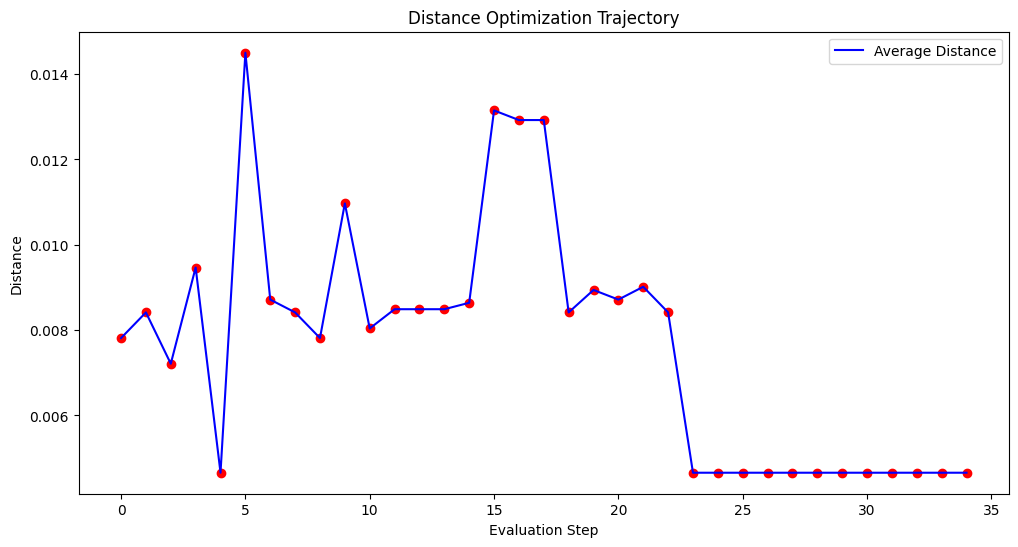

Best permutation: ['A1', 'D2', 'X', 'C2', 'A2', 'B1', 'D1', 'O2', 'C1', 'B2', 'O1']
Minimum average distance: 0.004658151765589782
Using first tree's order for initial order.
Best permutation written to: alltrees.trees_first_tree_order.txt


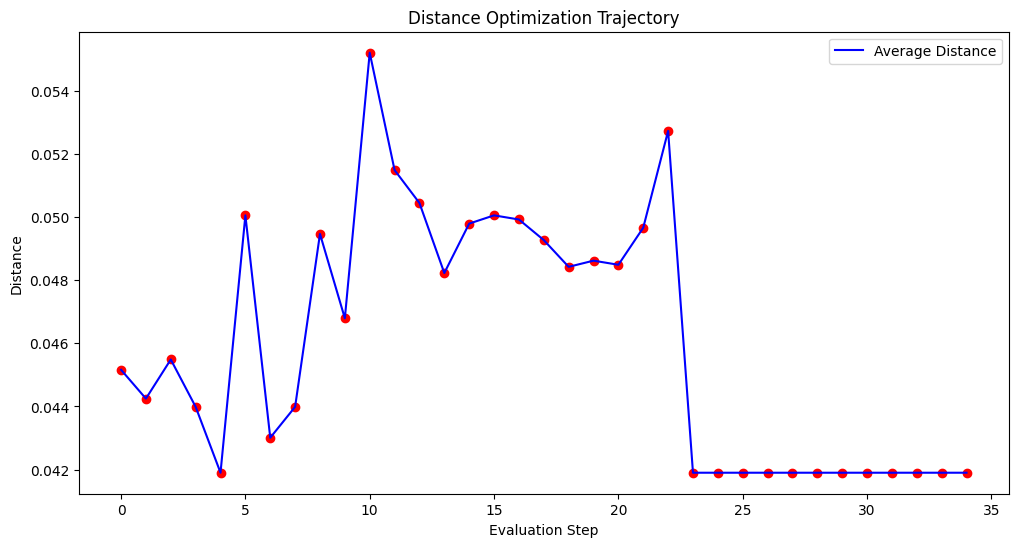

Best permutation: ['C1', 'B1', 'B2', 'A2', 'A1', 'O1', 'X', 'O2', 'C2', 'D2', 'D1']
Minimum average distance: 0.0419028999674161
Using MC for initial order. Distance: 0.05311176278918214
Best permutation written to: alltrees.trees_mc_order.txt


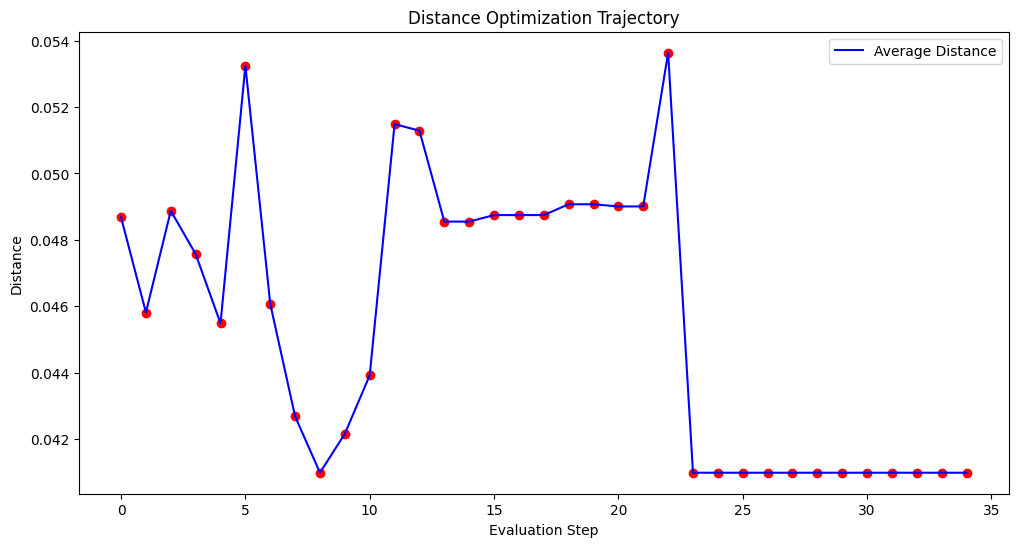

Best permutation: ['O1', 'C2', 'D1', 'C1', 'A1', 'A2', 'X', 'B1', 'O2', 'B2', 'D2']
Minimum average distance: 0.04099055066797002
Using MCTE for initial order. Distance: 0.05311176278918214
Best permutation written to: alltrees.trees_mcte_order.txt


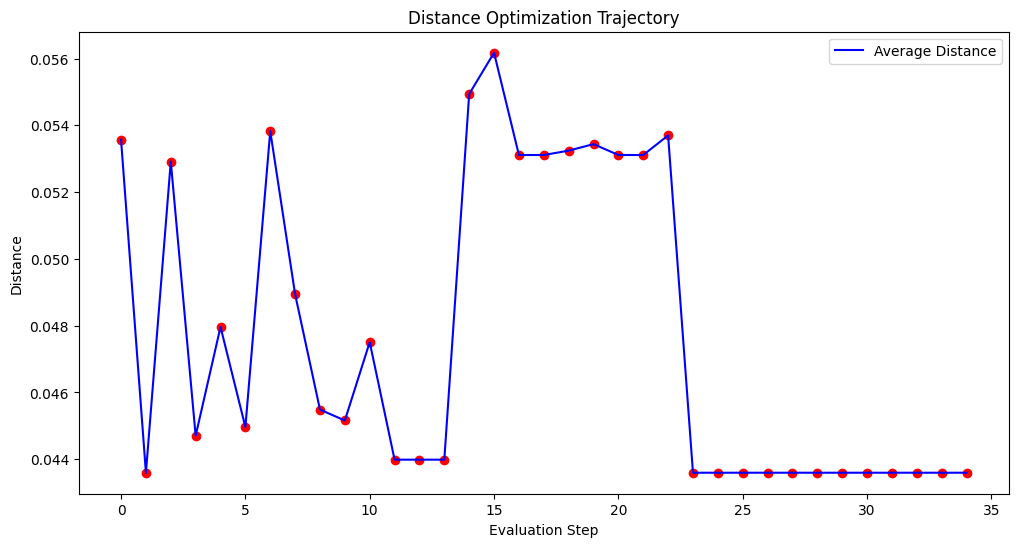

Best permutation: ['O1', 'C2', 'B2', 'B1', 'A2', 'O2', 'X', 'D1', 'C1', 'A1', 'D2']
Minimum average distance: 0.043597262952101666


In [7]:
# Example usage
optimize_tree_order(
    "./../data/alltrees.trees_cutted.newick", initial_order_option="first_tree", max_iter=1
)
optimize_tree_order(
    "./../data/alltrees.trees_cutted.newick", initial_order_option="mc", max_iter=1
)
optimize_tree_order(
    "./../data/alltrees.trees_cutted.newick", initial_order_option="mcte", max_iter=1
)

# Example usage
optimize_tree_order(
    "./../data/alltrees.trees.newick", initial_order_option="first_tree", max_iter=1
)
optimize_tree_order(
    "./../data/alltrees.trees.newick", initial_order_option="mc", max_iter=1
)
optimize_tree_order(
    "./../data/alltrees.trees.newick", initial_order_option="mcte", max_iter=1
)